In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);
    plt.yscale('log')

# Adres≥1kBTC

In [104]:
ad = pd.read_csv("data/adres≥1kBTC.csv".format(tiker))

In [105]:
ad['date'] = pd.to_datetime(ad['t'],unit='s').dt.date
#ad.set_index('date', inplace=True)
del ad['t']

In [106]:
ad.head()

,v,date
0,330,2010-12-16
1,336,2010-12-17
2,335,2010-12-18
3,336,2010-12-19
4,338,2010-12-20


In [107]:
ad = ad.loc[ad['date'] >= date(2013, 1, 1)]
ad = ad.set_index('date')

In [108]:
ad.head()

,v
date,
2013-01-01,1259
2013-01-02,1256
2013-01-03,1257
2013-01-04,1256
2013-01-05,1255


In [109]:
ad.tail()

,v
date,
2020-02-07,2136
2020-02-08,2141
2020-02-09,2163
2020-02-10,2164
2020-02-11,2162


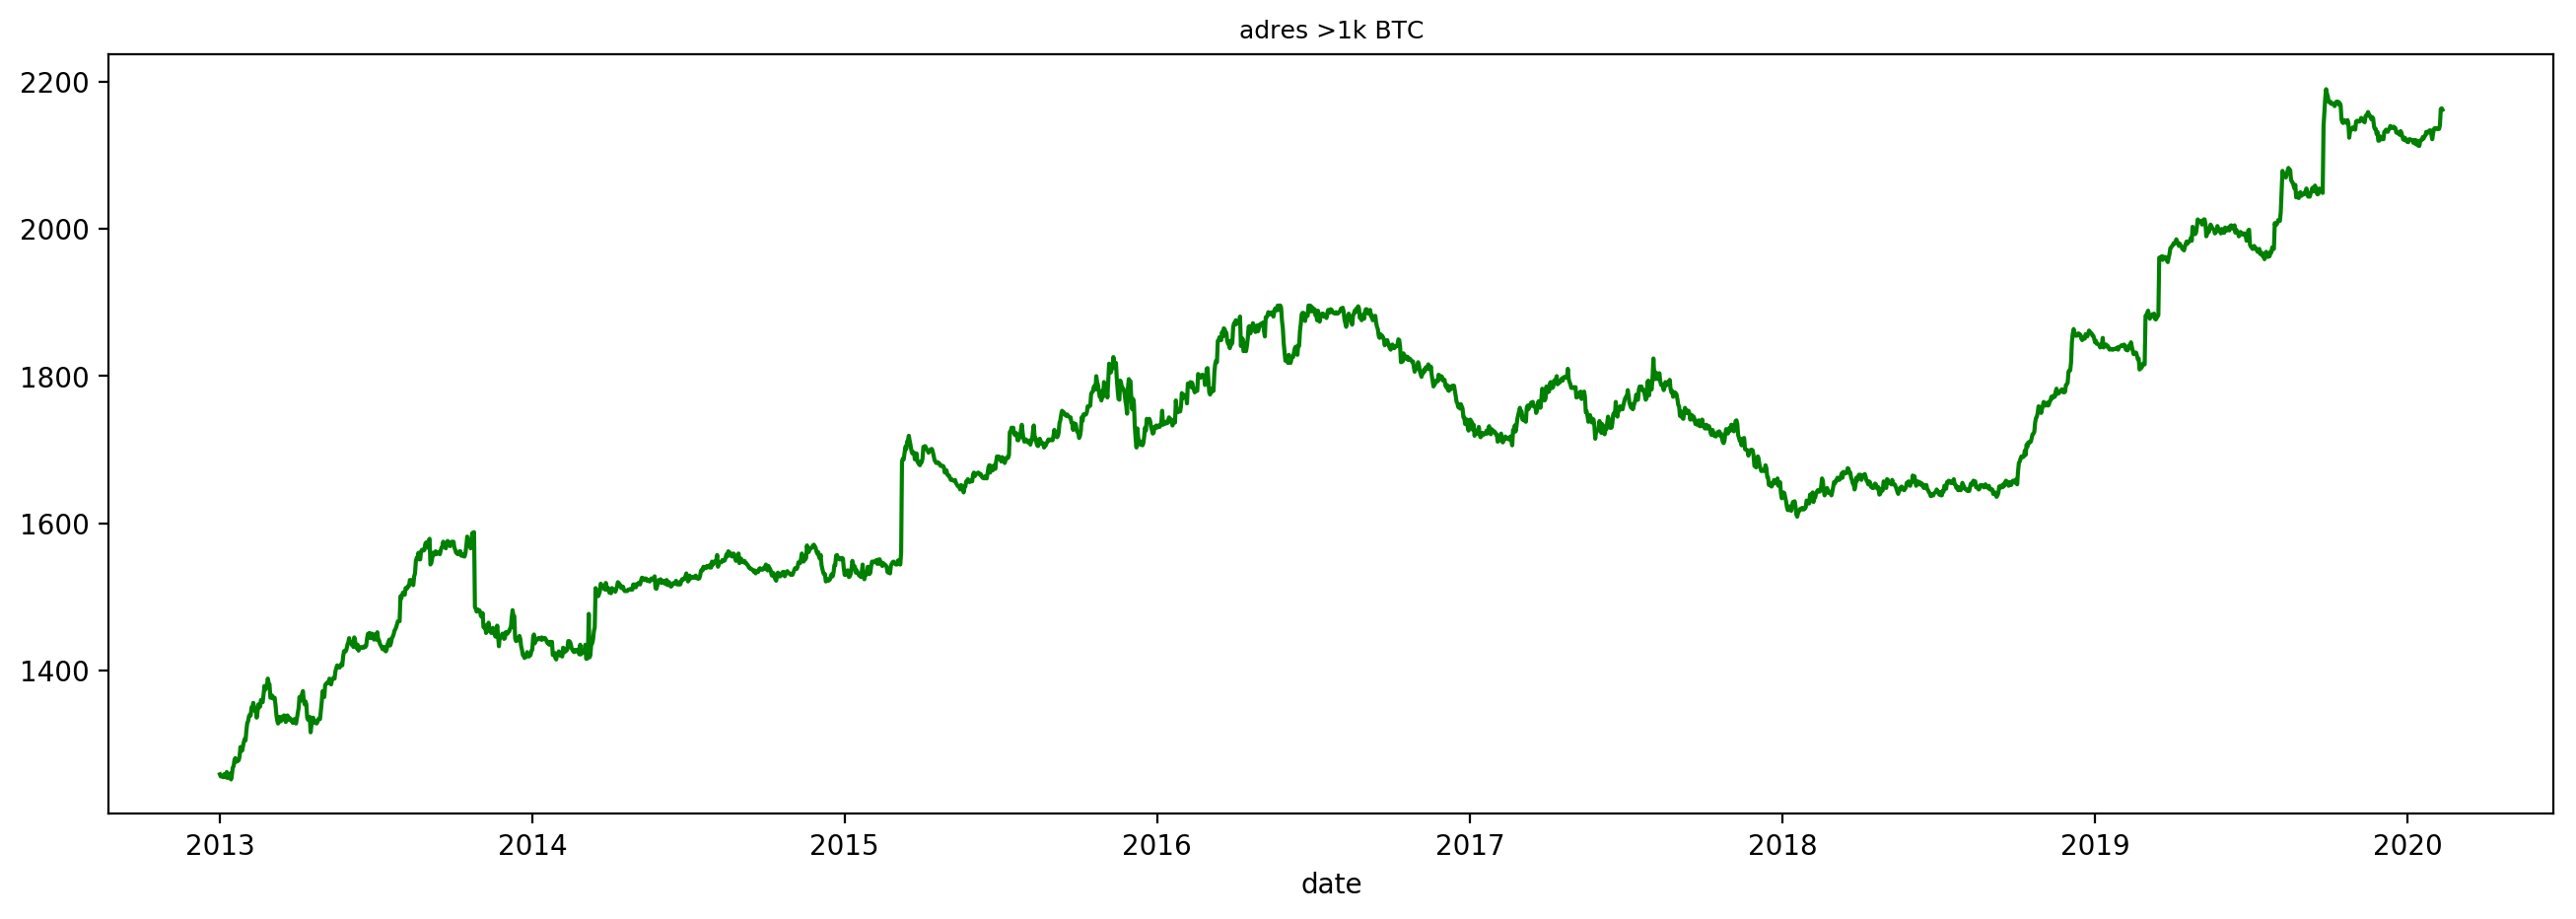

In [132]:
fig, ax = plt.subplots(figsize=[16, 5])

ad['v'].plot(color='g')
ax.set_xlabel('')

#plt.legend()
plt.title('adres >1k BTC', fontsize = 9)
#plt.yscale('log')
plt.show()

## CoinMetrics

In [146]:
data = OrderedDict()

# Список финансовых инструментов в портфеле
TIKERS = ['BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['PriceUSD']

In [147]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/Coinmetrics/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    #data[tiker] = pd.read_csv("data/{}.csv".format(tiker), parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['index'] = range(0, len(data[tiker]))
    
    data[tiker]['date'] = data[tiker].index
    
    data[tiker] = data[tiker].set_index('index')
    
    data[tiker] = data[tiker].loc[data[tiker]['date'] >= datetime(2013, 1, 1)]
    data[tiker] = data[tiker].loc[data[tiker]['date'] <= datetime(2020, 2, 11)]

    data[tiker] = data[tiker].set_index('date')
    data[tiker] = data[tiker].rename({'PriceUSD': 'Price USD'}, axis=1)
    data[tiker]['Number of addresses'] = ad['v']
    print(data[tiker].head())

            Price USD  Number of addresses
date                                      
2013-01-01  13.331371                 1259
2013-01-02  13.280607                 1256
2013-01-03  13.384081                 1257
2013-01-04  13.451721                 1256
2013-01-05  13.459407                 1255


In [148]:
data['BTC'].tail()

,Price USD,Number of addresses
date,,
2020-02-07,9800.279400,2136
2020-02-08,9911.293408,2141
2020-02-09,10151.083203,2163
2020-02-10,9872.361873,2164
2020-02-11,10272.222556,2162


In [186]:
data['BTC']['PriceMA'] = data['BTC']['Price USD'].rolling(window=100, min_periods=0).mean()
data['BTC']['NumberMA'] = data['BTC']['Number of addresses'].rolling(window=100, min_periods=0).mean()

In [187]:
data['BTC'].head()

,Price USD,Number of addresses,PriceMA,NumberMV,NumberMA
date,,,,,
2013-01-01,13.331371,1259,13.331371,1259.000000,1259.000000
2013-01-02,13.280607,1256,13.305989,1257.500000,1257.500000
2013-01-03,13.384081,1257,13.332020,1257.333333,1257.333333
2013-01-04,13.451721,1256,13.361945,1257.000000,1257.000000
2013-01-05,13.459407,1255,13.381437,1256.600000,1256.600000


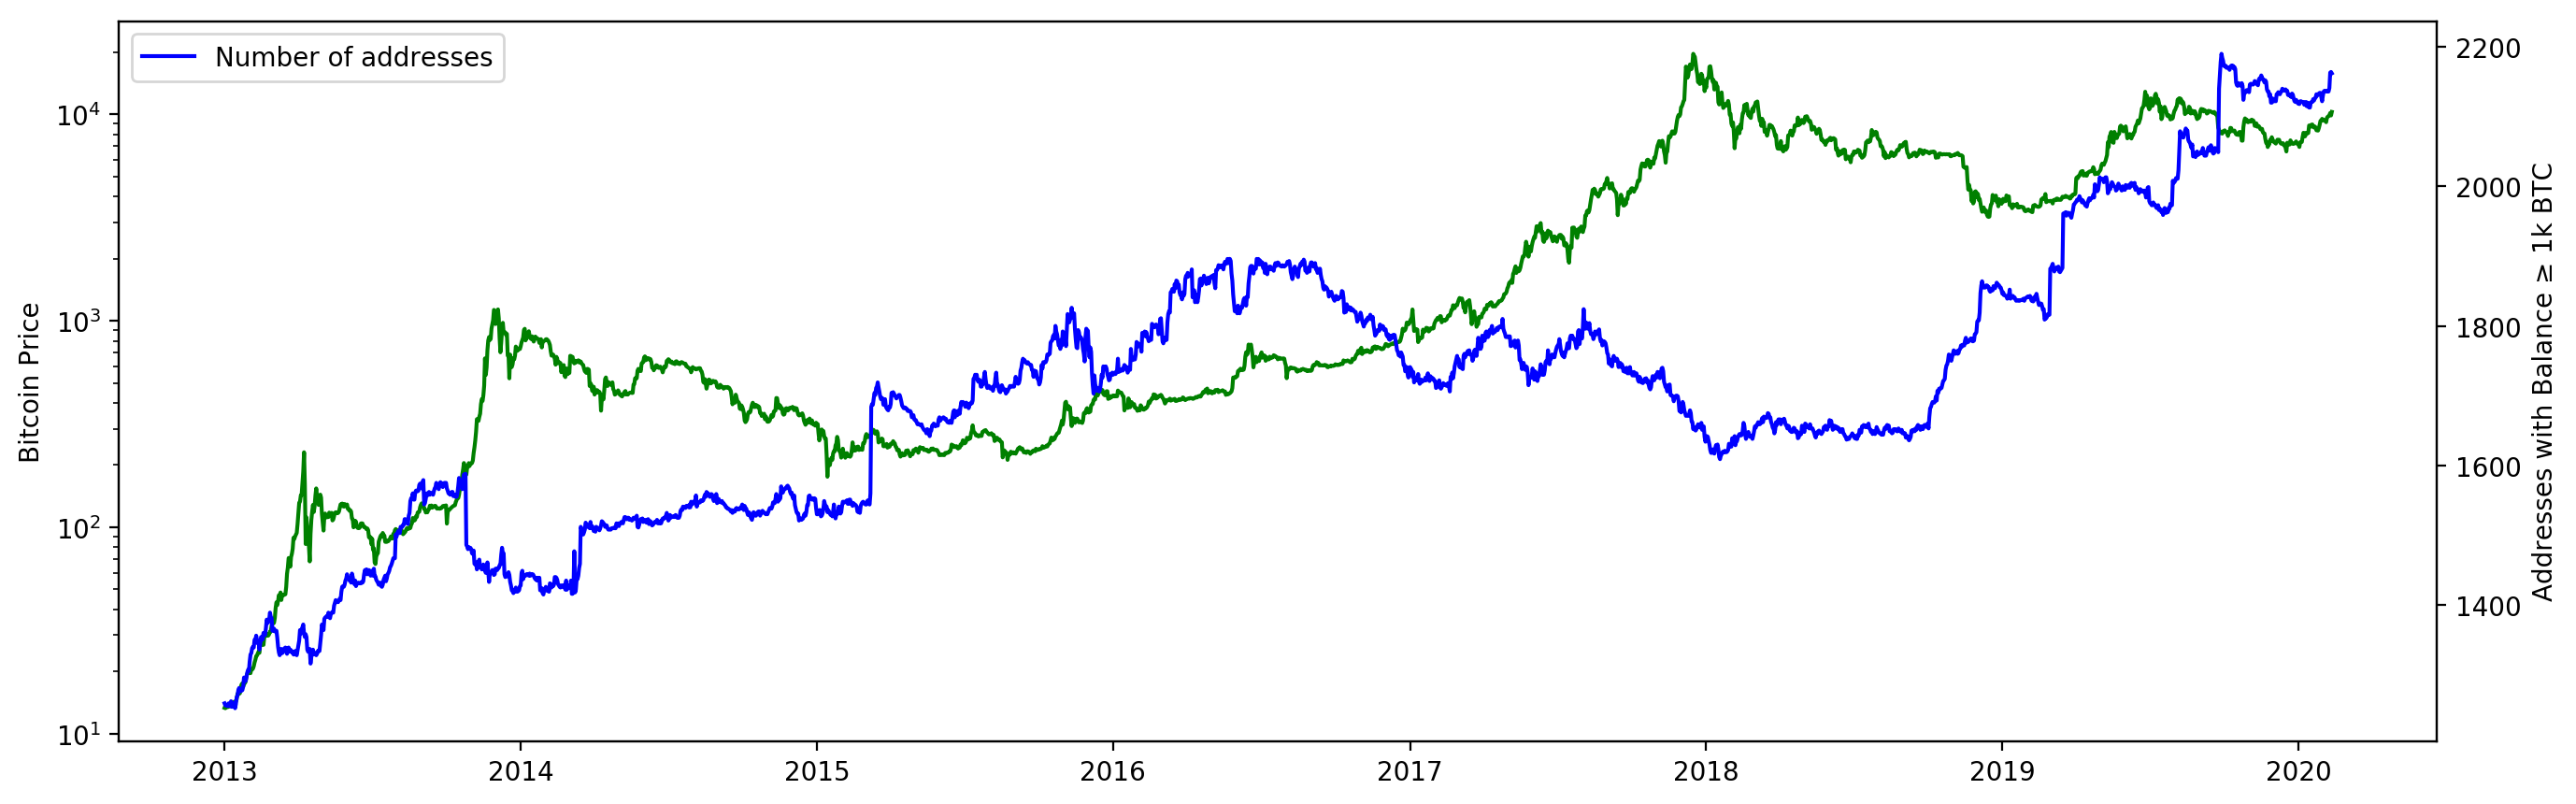

In [188]:
fig, ax = plt.subplots(figsize=[16, 5])

ax.plot(data['BTC']['Price USD'], color='g')
ax.set_xlabel('')
ax.set_ylabel('Bitcoin Price')
#ax.legend(('Price USD'))
#ax.tick_params(axais = 'x', direction = 'out')

#plt.yscale('log')
#plt.title('BTC price', fontsize = 9)
plt.yscale('log')

ax2=ax.twinx()
ax2.plot(data['BTC']['Number of addresses'], color='blue')
ax2.set_ylabel('Addresses with Balance ≥ 1k BTC')

plt.legend()

plt.show()

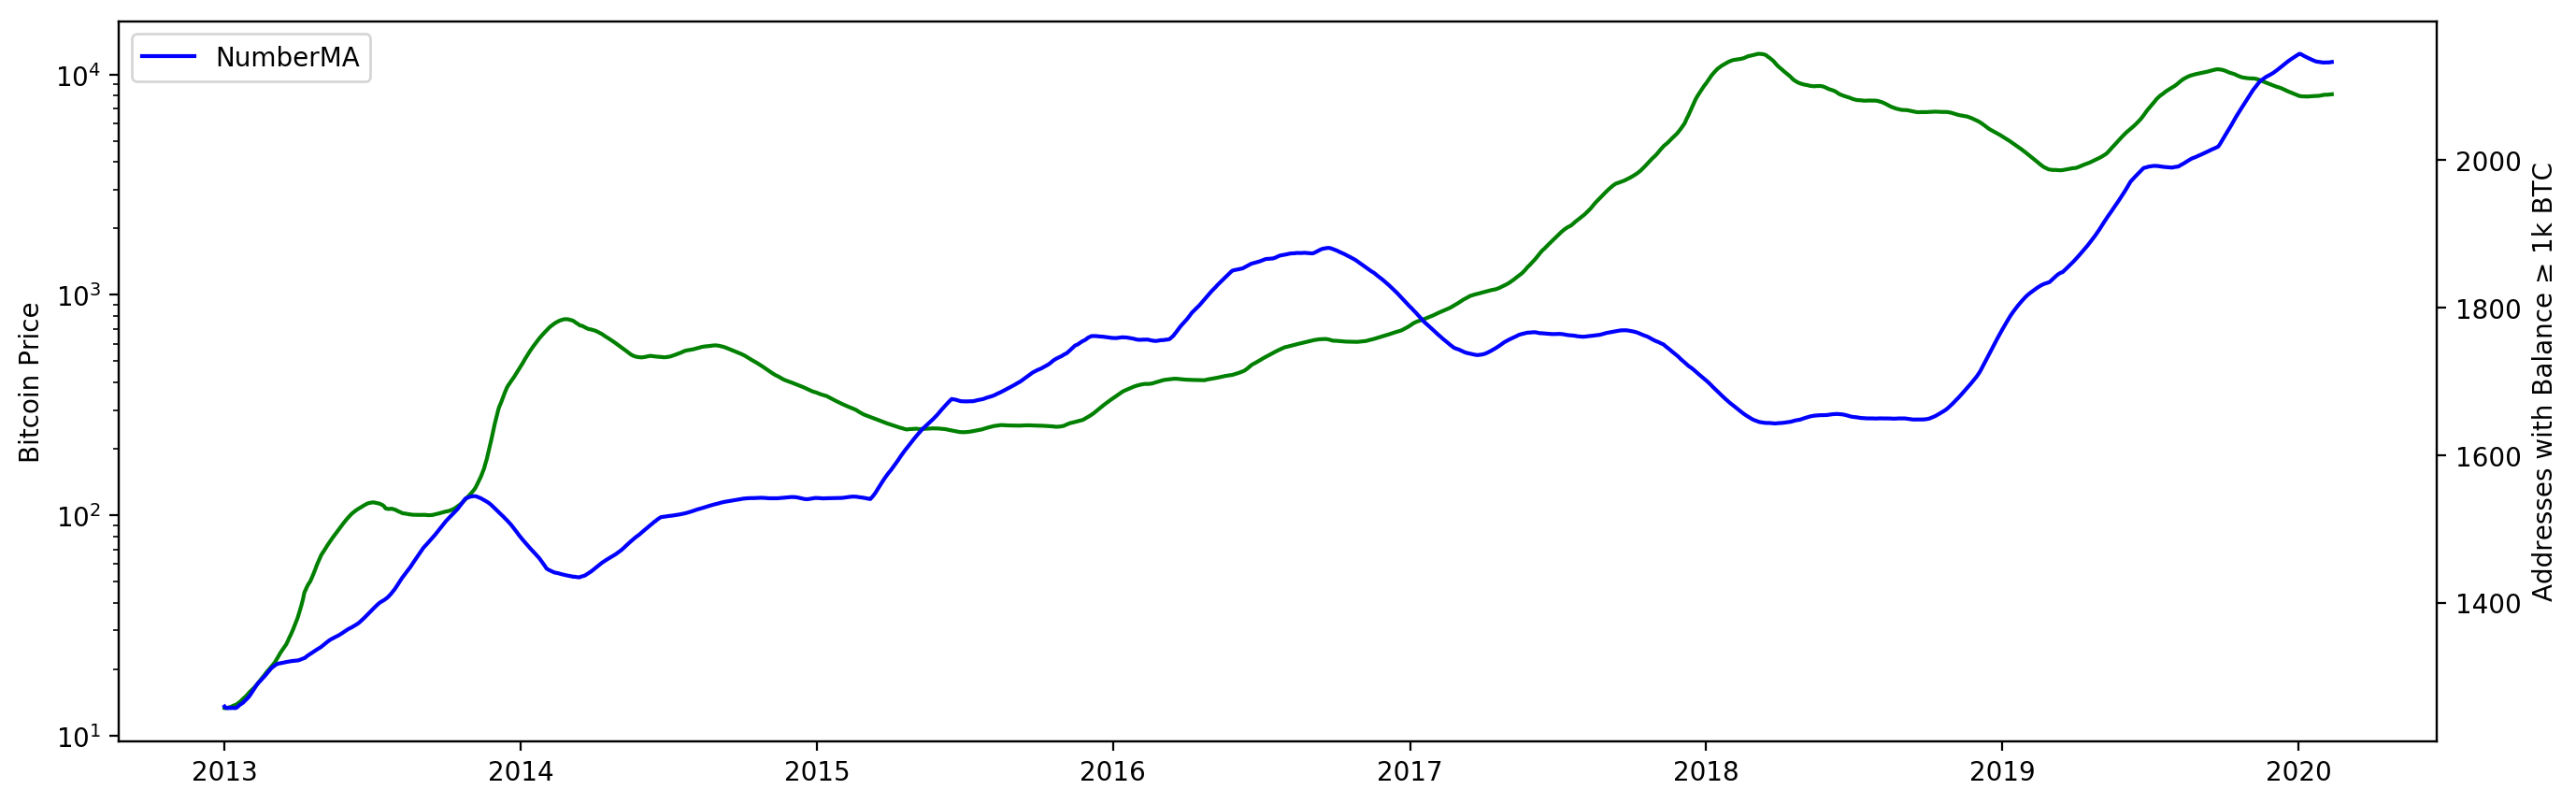

In [189]:
fig, ax = plt.subplots(figsize=[16, 5])

ax.plot(data['BTC']['PriceMA'], color='g')
ax.set_xlabel('')
ax.set_ylabel('Bitcoin Price')
#ax.legend(('Price USD'))
#ax.tick_params(axais = 'x', direction = 'out')

#plt.yscale('log')
#plt.title('BTC price', fontsize = 9)
plt.yscale('log')

ax2=ax.twinx()
ax2.plot(data['BTC']['NumberMA'], color='blue')
ax2.set_ylabel('Addresses with Balance ≥ 1k BTC')

plt.legend()

plt.show()

In [190]:
fig.savefig('price&addres.png', transparent=False, dpi=500, bbox_inches="tight")

In [116]:
data['BTC'].corr(method='pearson')

,price,ad
price,1.000000,0.469259
ad,0.469259,1.000000


In [117]:
data['BTC'].corr(method='pearson').values[0][1]

0.4692592349074275

In [118]:
corr_list = []
corr_list.append(data['BTC'].corr(method='pearson').values[0][1])

In [119]:
for shift in tqdm(range(0, 300)):
    data['BTC'].ad = data['BTC'].ad.shift(1)
    data['BTC'].dropna()
    corr_list.append(data['BTC'].corr(method='pearson').values[0][1])

100%|██████████| 300/300 [00:00<00:00, 938.50it/s]


In [121]:
#corr_list

In [122]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/Coinmetrics/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    #data[tiker] = pd.read_csv("data/{}.csv".format(tiker), parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['index'] = range(0, len(data[tiker]))
    
    data[tiker]['date'] = data[tiker].index
    
    data[tiker] = data[tiker].set_index('index')
    
    data[tiker] = data[tiker].loc[data[tiker]['date'] >= datetime(2013, 1, 1)]
    data[tiker] = data[tiker].loc[data[tiker]['date'] <= datetime(2020, 2, 11)]

    data[tiker] = data[tiker].set_index('date')
    data[tiker] = data[tiker].rename({'PriceUSD': 'price'}, axis=1)
    data[tiker]['ad'] = ad['v']
    print(data[tiker].head())

                price    ad
date                       
2013-01-01  13.331371  1259
2013-01-02  13.280607  1256
2013-01-03  13.384081  1257
2013-01-04  13.451721  1256
2013-01-05  13.459407  1255


In [123]:
neg_corr_list = []
for shift in tqdm(range(0, 300)):
    data['BTC'].ad = data['BTC'].ad.shift(-1)
    data['BTC'].dropna()
    neg_corr_list.append(data['BTC'].corr(method='pearson').values[0][1])

100%|██████████| 300/300 [00:00<00:00, 979.37it/s]


In [124]:
neg_corr_list.reverse()

In [125]:
#neg_corr_list

In [126]:
final_list = neg_corr_list + corr_list

In [127]:
len(final_list)

601

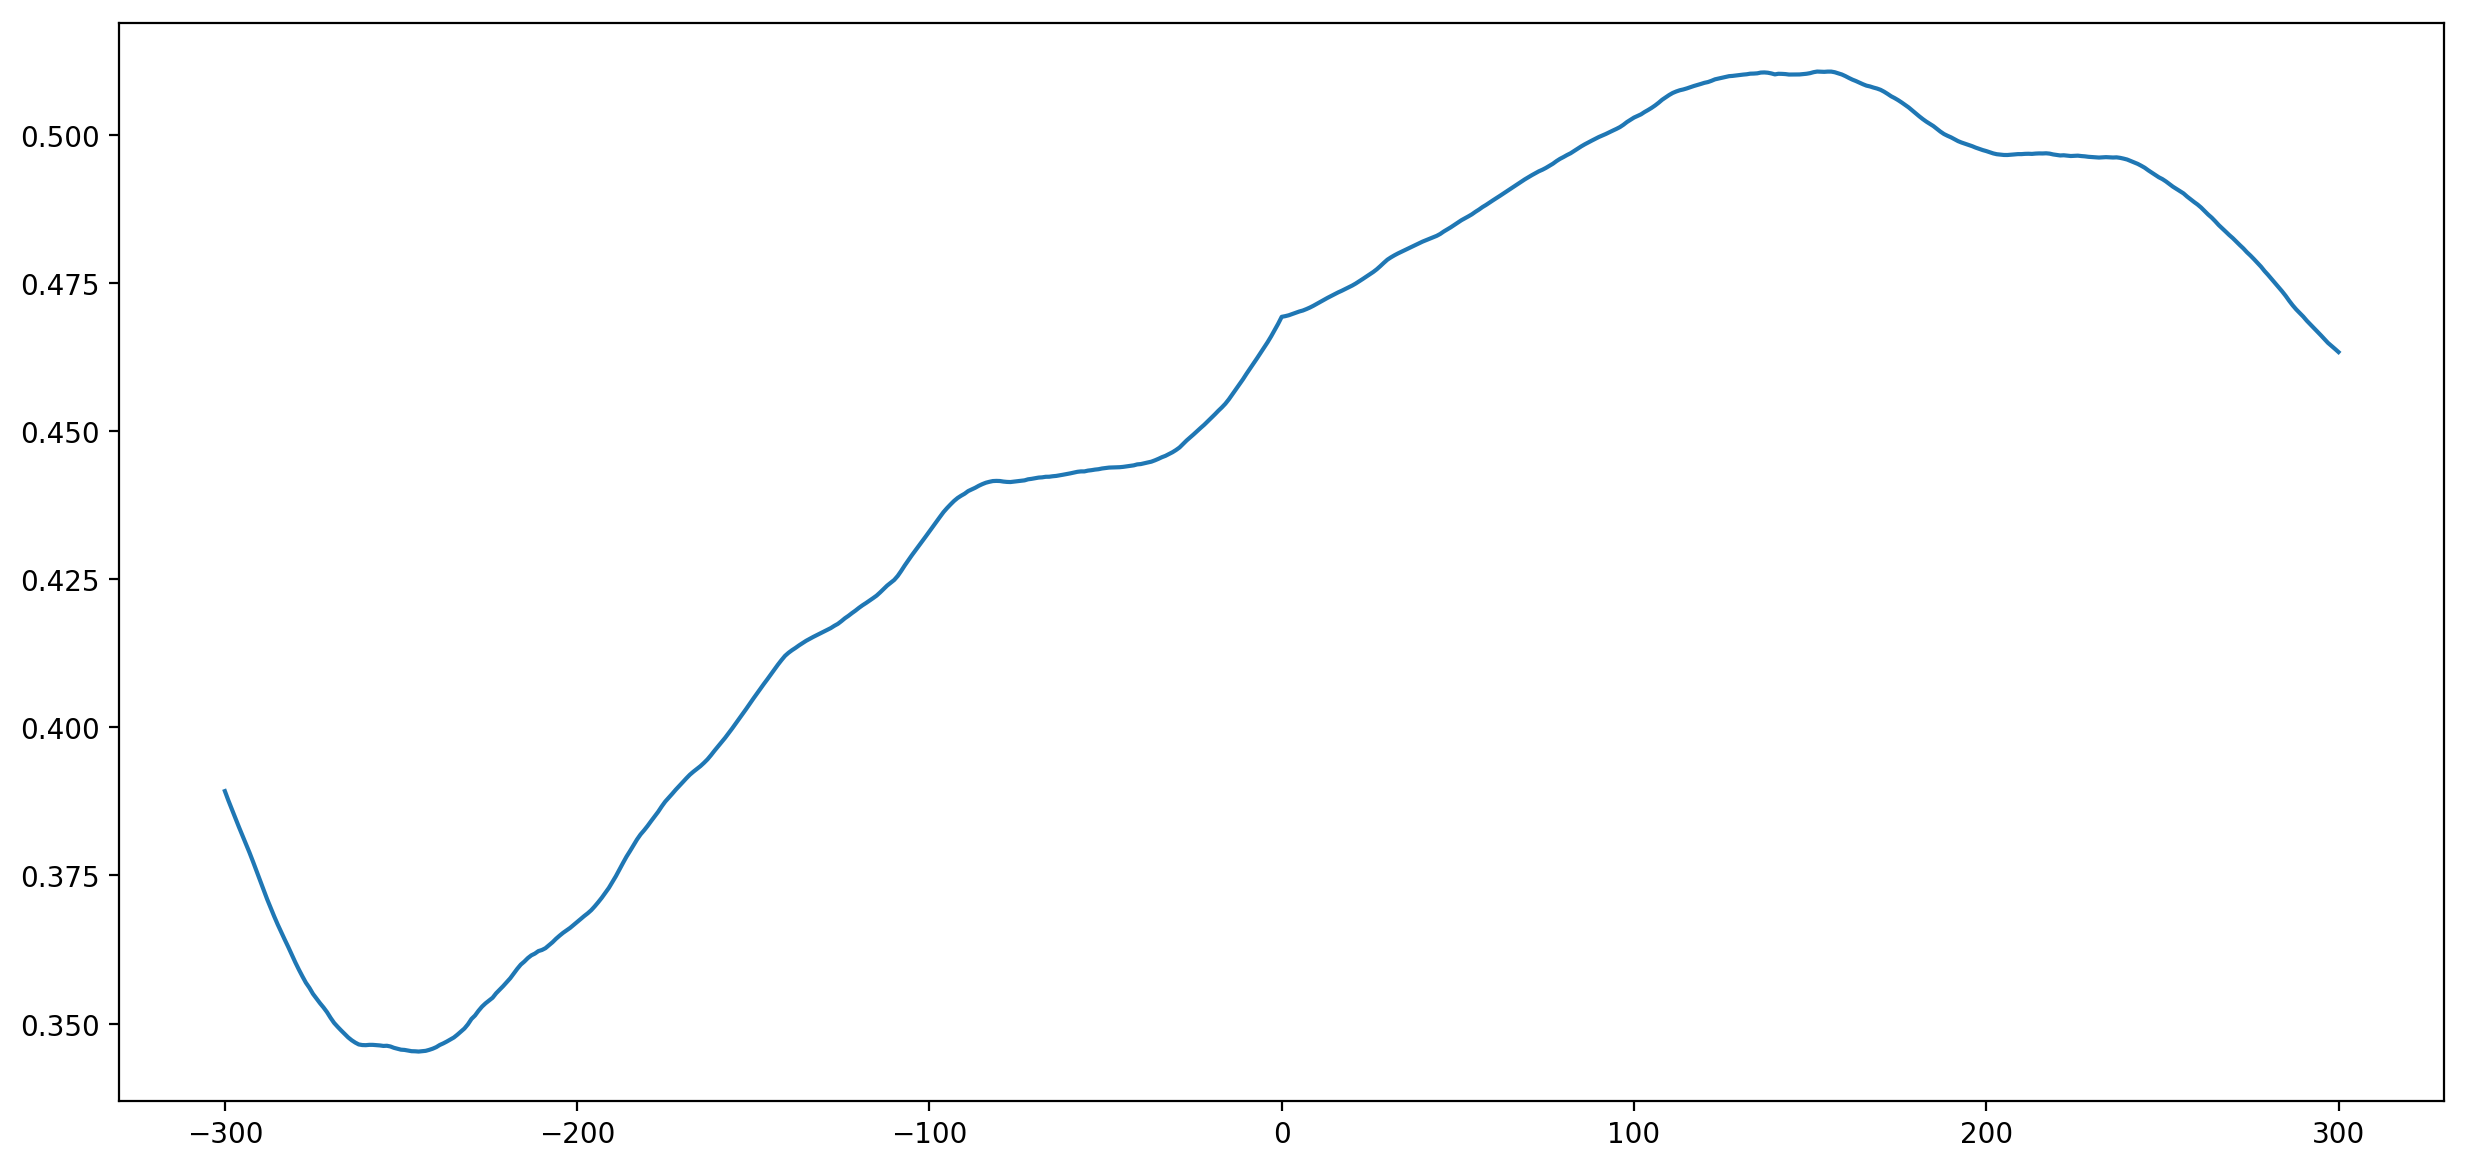

In [128]:
xlist = range(-300, 301)
ylist = final_list
plt.plot(xlist, ylist)
plt.show()